# Portfolio Optimization Lab

This notebook demonstrates end-to-end portfolio optimization using quantitative finance techniques. We'll explore various optimization methods, evaluate performance, and compare strategies using real market data.

## What You'll Learn
- **Data Processing**: Fetch and clean financial data from Yahoo Finance
- **Optimization Methods**: Mean-Variance, CVaR, and Black-Litterman
- **Performance Analysis**: Sharpe ratio, maximum drawdown, risk metrics
- **Strategy Comparison**: Backtesting multiple approaches
- **Machine Learning**: ML-enhanced portfolio optimization

## Methodology Overview

### 1. **Data Acquisition & Processing**
- **Source**: Yahoo Finance API (free, reliable)
- **Assets**: 16 major US stocks across sectors
- **Period**: 10 years of historical data
- **Quality**: Missing value handling, data validation

### 2. **Core Optimization Methods**
- **Mean-Variance**: Classic Markowitz optimization
- **CVaR**: Conditional Value-at-Risk for tail risk
- **Black-Litterman**: Market views with prior beliefs
- **Parameter Sweep**: Systematic testing of settings

### 3. **Machine Learning Integration**
- **Features**: Technical indicators from price/volume
- **Models**: XGBoost and Random Forest
- **Training**: Multi-symbol, long historical period
- **Application**: ML overlay for enhanced returns

### 4. **Performance Evaluation**
- **Return Metrics**: Annualized return, total return
- **Risk Metrics**: Volatility, Sharpe ratio, max drawdown
- **Risk-Adjusted**: Sortino, Calmar, Information ratio
- **Benchmarking**: SPY and equal-weight comparison

### 5. **Walk-Forward Backtesting**
- **Framework**: 3-year training, 2-quarter testing
- **Costs**: 7.5 bps transaction costs
- **Rebalancing**: Rolling window optimization
- **Strategies**: Multiple methods compared

### Key Outputs
- Optimized portfolio weights for each method
- Performance metrics and risk analysis
- Visualizations: Equity curves, drawdowns, efficient frontier
- Backtest reports with transaction costs
- ML model performance and feature importance

## Imports & Configuration

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from __future__ import annotations

import os
import math
import time
import logging

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.optimizer.optimizer import SimplePortfolioOptimizer
from portfolio.performance.calculator import SimplePerformanceCalculator
from portfolio.performance.visualization import (
    plot_equity_curve,
    plot_drawdown_curve,
)

# Symbols and period
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN",
    "META", "NVDA", "NFLX", "TSLA",
    "JPM", "JNJ", "PG", "HD",
    "DIS", "V", "MA", "UNH",
]
# Use longer history by default to stabilize risk estimates
period = "10y"

# Output paths
FIG_DIR = os.path.join("examples", "figures")
OUT_DIR = os.path.join("examples", "outputs")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

plt.style.use("seaborn-v0_8-whitegrid")
print(f"Symbols: {symbols}, Period: {period}")


Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'NFLX', 'TSLA', 'JPM', 'JNJ', 'PG', 'HD', 'DIS', 'V', 'MA', 'UNH'], Period: 10y


## Data Fetch & Processing

In [3]:
# Data fetch and quick QA
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

# Show available offline cache (raw/processed/combined)
available = service.list_available_offline_data()
print("Offline data files:", {k: len(v) for k, v in available.items()})

# Consolidated adjusted close prices for selected symbols
prices = service.fetch_price_data(symbols, period)

# If the combined cache doesn't include all symbols, rebuild from per-symbol offline data
if prices.shape[1] < len(symbols):
    cols = []
    for s in symbols:
        try:
            df = service.fetch_historical_data(s, period)
            if not df.empty and "Adj Close" in df:
                cols.append(df["Adj Close"].rename(s))
        except Exception as e:
            print(f"Missing or failed for {s}: {e}")
    if cols:
        rebuilt = pd.concat(cols, axis=1).dropna()
        missing = [s for s in symbols if s not in rebuilt.columns]
        if missing:
            print("Symbols missing in rebuilt combined:", missing)
        prices = rebuilt

print("Prices shape:", prices.shape)
print(prices.head())
start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")
print("Backtest window:", start_date, "to", end_date)

# Per-symbol pipeline and quality report preview
pipeline = service.fetch_and_process_data(symbols, period)

rows = []
for sym, res in pipeline.items():
    if res.get("success"):
        q = res.get("quality_report", {})
        rows.append({
            "symbol": sym,
            "rows": q.get("data_summary", {}).get("total_rows"),
            "completeness": q.get("quality_metrics", {}).get("completeness"),
            "vol_annualized": q.get("quality_metrics", {}).get("volatility_annualized"),
        })
summary = pd.DataFrame(rows).set_index("symbol").sort_index()
print(summary.to_string())

2025-09-25 02:48:18,069 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-25 02:48:18,085 - portfolio.data.yahoo_service - INFO - Fetching online price data for 16 symbols


Offline data files: {'raw': 35, 'processed': 4, 'combined': 4}


[*********************100%***********************]  16 of 16 completed
2025-09-25 02:48:19,982 - portfolio.data.yahoo_service - INFO - Saved combined price data to data\processed\combined_10y_prices.csv
2025-09-25 02:48:19,982 - portfolio.data.yahoo_service - INFO - Fetched price data for 16 symbols
2025-09-25 02:48:19,988 - portfolio.data.yahoo_service - INFO - Processing data for AAPL
2025-09-25 02:48:20,007 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-25 02:48:20,012 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-25 02:48:20,039 - portfolio.data.yahoo_service - INFO - Generated quality report for AAPL
2025-09-25 02:48:20,039 - portfolio.data.yahoo_service - INFO - Successfully processed data for AAPL
2025-09-25 02:48:20,039 - portfolio.data.yahoo_service - INFO - Processing data for MSFT
2025-09-25 02:48:20,055 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-0

Prices shape: (2514, 16)
Ticker           AAPL       AMZN        DIS      GOOGL         HD        JNJ  \
Date                                                                           
2015-09-25  25.778271  26.212500  92.482880  31.788254  92.186142  68.916847   
2015-09-28  25.268141  25.202999  90.813934  30.998697  90.101395  69.197052   
2015-09-29  24.508570  24.803499  91.671455  30.917261  89.161697  70.461792   
2015-09-30  24.787235  25.594500  94.234779  31.699863  91.199028  70.696579   
2015-10-01  24.625427  26.035999  94.668159  31.880119  92.415123  70.560242   

Ticker            JPM         MA       META       MSFT        NFLX      NVDA  \
Date                                                                           
2015-09-25  46.792564  85.940277  92.201607  38.288265  102.239998  0.573762   
2015-09-28  45.658344  83.163460  88.663414  37.721863   99.470001  0.566229   
2015-09-29  45.551769  83.549393  86.138977  37.852558   98.349998  0.576192   
2015-09-30  46

2025-09-25 02:48:20,193 - portfolio.data.yahoo_service - INFO - Generated quality report for AMZN
2025-09-25 02:48:20,193 - portfolio.data.yahoo_service - INFO - Successfully processed data for AMZN
2025-09-25 02:48:20,194 - portfolio.data.yahoo_service - INFO - Processing data for META
2025-09-25 02:48:20,210 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (10y): 2514 rows
2025-09-25 02:48:20,216 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-25 02:48:20,244 - portfolio.data.yahoo_service - INFO - Generated quality report for META
2025-09-25 02:48:20,244 - portfolio.data.yahoo_service - INFO - Successfully processed data for META
2025-09-25 02:48:20,244 - portfolio.data.yahoo_service - INFO - Processing data for NVDA
2025-09-25 02:48:20,261 - portfolio.data.yahoo_service - INFO - Loaded offline data for NVDA (10y): 2514 rows
2025-09-25 02:48:20,266 - portfolio.data.yahoo_service - INFO - Cleaned data: 2514 -> 2514 rows
2025-09-25 0

        rows  completeness  vol_annualized
symbol                                    
AAPL    2514           1.0        0.292105
AMZN    2514           1.0        0.327837
DIS     2514           1.0        0.284588
GOOGL   2514           1.0        0.286895
HD      2514           1.0        0.245323
JNJ     2514           1.0        0.183612
JPM     2514           1.0        0.276172
MA      2514           1.0        0.269051
META    2514           1.0        0.384085
MSFT    2514           1.0        0.269548
NFLX    2514           1.0        0.422336
NVDA    2514           1.0        0.499052
PG      2514           1.0        0.187084
TSLA    2514           1.0        0.592329
UNH     2514           1.0        0.290954
V       2514           1.0        0.246139


### Data sanity checks

In [4]:
# Returns computation
asset_returns = prices.pct_change().dropna()
print("Returns shape:", asset_returns.shape)
print(asset_returns.describe().T[["mean", "std"]])

corr = asset_returns.corr()
print("Pairwise correlations:")
print(corr)

Returns shape: (2513, 16)
            mean       std
Ticker                    
AAPL    0.001077  0.018400
AMZN    0.001060  0.020641
DIS     0.000241  0.017927
GOOGL   0.000980  0.018069
HD      0.000714  0.015450
JNJ     0.000442  0.011569
JPM     0.000908  0.017393
MA      0.000895  0.016939
META    0.001135  0.024187
MSFT    0.001175  0.016980
NFLX    0.001343  0.026604
NVDA    0.002773  0.031442
PG      0.000474  0.011785
TSLA    0.001988  0.037314
UNH     0.000674  0.018321
V       0.000771  0.015476
Pairwise correlations:
Ticker      AAPL      AMZN       DIS     GOOGL        HD       JNJ       JPM  \
Ticker                                                                         
AAPL    1.000000  0.576512  0.426937  0.612246  0.500504  0.308948  0.422386   
AMZN    0.576512  1.000000  0.389482  0.651250  0.417038  0.175824  0.313843   
DIS     0.426937  0.389482  1.000000  0.421068  0.461086  0.270564  0.546653   
GOOGL   0.612246  0.651250  0.421068  1.000000  0.450133  0.26504

## Portfolio Optimization Methods Overview

This section compares different portfolio optimization approaches to help you choose the best method for your investment objectives.

### Key Optimization Methods

#### 1. **Mean-Variance Optimization (MVO)**
- **Goal**: Maximize risk-adjusted returns (Sharpe ratio)
- **Approach**: Classic Markowitz optimization
- **Strengths**: High return potential, mathematically elegant
- **Weaknesses**: Sensitive to inputs, high concentration risk
- **Best for**: Growth-focused investors with high risk tolerance

#### 2. **Conditional Value-at-Risk (CVaR)**  
- **Goal**: Minimize tail risk and extreme losses
- **Approach**: Focuses on worst-case scenarios (5% tail)
- **Strengths**: Superior drawdown control, lower volatility
- **Weaknesses**: Lower returns, more conservative allocations
- **Best for**: Capital preservation, risk management focus

#### 3. **Black-Litterman (BL)**
- **Goal**: Combine market equilibrium with investor views
- **Approach**: Bayesian updating of market-implied returns
- **Strengths**: More stable weights, intuitive view incorporation
- **Weaknesses**: Requires view specification, moderate complexity
- **Best for**: Investors with strong market views

#### 4. **Risk Parity**
- **Goal**: Equal risk contribution across assets
- **Approach**: Inverse volatility weighting
- **Strengths**: Maximum diversification, low concentration
- **Weaknesses**: Moderate returns, may underperform in bull markets
- **Best for**: Stability-focused investors

### Method Selection Framework

| Objective              | Recommended Method | Expected Return | Risk Level |
|------------------------|-------------------|-----------------|------------|
| **Maximum Return**     | MVO               | 40%+            | High       |
| **Capital Protection** | CVaR              | 25-30%          | Low        |
| **Balanced Growth**    | Black-Litterman   | 30-35%          | Medium     |
| **Stability**          | Risk Parity       | 20-25%          | Very Low   |

Let's now implement and compare these methods...

In [5]:
# Comprehensive Optimization Methods Comparison
print("=== Portfolio Optimization Methods Comparison ===")

# Initialize optimizer and performance calculator
opt = SimplePortfolioOptimizer()
perf = SimplePerformanceCalculator()

# Fetch SPY benchmark data for comparison
try:
    spy = service.fetch_price_data(["SPY"], period)
    benchmark_returns = spy.pct_change().dropna().iloc[:, 0]
    print(f"SPY benchmark data loaded: {len(benchmark_returns)} observations")
except Exception as e:
    print(f"Could not load SPY benchmark data: {e}")
    benchmark_returns = None

results = {}

# 1. Mean-Variance Optimization
print("\n1. Running Mean-Variance Optimization...")
mvo = opt.mean_variance_optimize(
    asset_returns,
    risk_model='ledoit_wolf',
    weight_cap=0.18,
    entropy_penalty=0.03,
)
weights_mvo = pd.Series(mvo['weights'])
returns_mvo = (asset_returns * weights_mvo).sum(axis=1)
metrics_mvo = perf.calculate_metrics(returns_mvo, benchmark_returns)

results['MVO'] = {
    'weights': weights_mvo,
    'returns': returns_mvo,
    'metrics': metrics_mvo,
    'expected_return': mvo['expected_return'],
    'expected_volatility': mvo['expected_volatility'],
    'sharpe_ratio': mvo['sharpe_ratio']
}

# 2. CVaR Optimization
print("2. Running CVaR Optimization...")
cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
weights_cvar = pd.Series(cvar['weights'])
returns_cvar = (asset_returns * weights_cvar).sum(axis=1)
metrics_cvar = perf.calculate_metrics(returns_cvar, benchmark_returns)

results['CVaR'] = {
    'weights': weights_cvar,
    'returns': returns_cvar,
    'metrics': metrics_cvar,
    'expected_return': cvar['expected_return'],
    'expected_volatility': cvar['expected_volatility'],
    'sharpe_ratio': cvar['sharpe_ratio']
}

# 3. Black-Litterman Optimization
print("3. Running Black-Litterman Optimization...")
bl = opt.black_litterman_optimize(asset_returns)
weights_bl = pd.Series(bl['weights'])
returns_bl = (asset_returns * weights_bl).sum(axis=1)
metrics_bl = perf.calculate_metrics(returns_bl, benchmark_returns)

results['BL'] = {
    'weights': weights_bl,
    'returns': returns_bl,
    'metrics': metrics_bl,
    'expected_return': bl['expected_return'],
    'expected_volatility': bl['expected_volatility'],
    'sharpe_ratio': bl['sharpe_ratio']
}

# 4. Risk Parity (Equal Risk Contribution)
print("4. Running Risk Parity...")
# Simple risk parity implementation
returns_cov = asset_returns.cov().values
inv_vol = 1.0 / np.sqrt(np.diag(returns_cov))
weights_rp = inv_vol / inv_vol.sum()
weights_rp = pd.Series(weights_rp, index=asset_returns.columns)

returns_rp = (asset_returns * weights_rp).sum(axis=1)
metrics_rp = perf.calculate_metrics(returns_rp, benchmark_returns)

results['RiskParity'] = {
    'weights': weights_rp,
    'returns': returns_rp,
    'metrics': metrics_rp,
    'expected_return': metrics_rp['annual_return'],
    'expected_volatility': metrics_rp['annual_volatility'],
    'sharpe_ratio': metrics_rp['sharpe_ratio']
}

# Create comprehensive comparison table
comparison_data = []
for method, data in results.items():
    weights = data['weights']
    metrics = data['metrics']
    
    comparison_data.append({
        'Method': method,
        'Annual Return': f"{metrics['annual_return']:.2%}",
        'Annual Volatility': f"{metrics['annual_volatility']:.2%}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.2f}",
        'Max Drawdown': f"{metrics['max_drawdown']:.2%}",
        'Beta': f"{metrics['beta']:.2f}",
        'Alpha': f"{metrics['alpha']:.2%}",
        'Top 3 Concentration': f"{weights.nlargest(3).sum():.1%}",
        'Effective N': f"{np.exp(-np.sum(weights * np.log(weights + 1e-12))):.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("OPTIMIZATION METHODS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Method rankings
print("\n" + "="*80)
print("METHOD RANKINGS")
print("="*80)

rankings = {}
key_metrics = ['sharpe_ratio', 'annual_return', 'max_drawdown']

for metric in key_metrics:
    if metric == 'max_drawdown':
        # Lower is better for drawdown
        ranking = comparison_df.sort_values('Max Drawdown', ascending=True)['Method'].tolist()
    else:
        # Higher is better for return and Sharpe
        metric_col = 'Sharpe Ratio' if metric == 'sharpe_ratio' else 'Annual Return'
        ranking = comparison_df.sort_values(metric_col, ascending=False)['Method'].tolist()
    
    rankings[metric] = ranking

print("\nPerformance Rankings:")
print(f"🏆 Best Sharpe Ratio: {rankings['sharpe_ratio'][0]}")
print(f"📈 Highest Return: {rankings['annual_return'][0]}")
print(f"🛡️ Best Drawdown Control: {rankings['max_drawdown'][0]}")

# Portfolio characteristics
print("\n" + "="*80)
print("PORTFOLIO COMPOSITION ANALYSIS")
print("="*80)

for method, data in results.items():
    weights = data['weights']
    top_holdings = weights.nlargest(3)
    print(f"\n{method} Top Holdings:")
    for asset, weight in top_holdings.items():
        print(f"  • {asset}: {weight:.1%}")
    print(f"  Total Top 3: {top_holdings.sum():.1%}")

2025-09-25 02:48:20,841 - portfolio.config - INFO - Loaded configuration from config.yaml
2025-09-25 02:48:20,841 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-25 02:48:20,859 - portfolio.data.yahoo_service - INFO - Fetching online price data for 1 symbols


=== Portfolio Optimization Methods Comparison ===


[*********************100%***********************]  1 of 1 completed
2025-09-25 02:48:21,109 - portfolio.data.yahoo_service - INFO - Saved combined price data to data\processed\combined_10y_prices.csv
2025-09-25 02:48:21,109 - portfolio.data.yahoo_service - INFO - Fetched price data for 1 symbols


SPY benchmark data loaded: 2513 observations

1. Running Mean-Variance Optimization...
2. Running CVaR Optimization...
3. Running Black-Litterman Optimization...
4. Running Risk Parity...

OPTIMIZATION METHODS COMPARISON
    Method Annual Return Annual Volatility Sharpe Ratio Max Drawdown Beta  Alpha Top 3 Concentration Effective N
       MVO        42.61%            29.92%         1.36      -48.88% 1.36 22.84%               54.0%         8.9
      CVaR        29.55%            19.10%         1.44      -32.06% 0.93 15.35%               68.8%         6.6
        BL        46.12%            31.97%         1.38      -51.08% 1.44 25.32%               63.4%         6.3
RiskParity        23.43%            19.25%         1.11      -30.81% 1.02  8.14%               26.8%        15.3

METHOD RANKINGS

Performance Rankings:
🏆 Best Sharpe Ratio: CVaR
📈 Highest Return: BL
🛡️ Best Drawdown Control: RiskParity

PORTFOLIO COMPOSITION ANALYSIS

MVO Top Holdings:
  • NVDA: 18.0%
  • TSLA: 18.0%
  • NFL

In [6]:
# Optimization Methods Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Equity Curves Comparison
ax1 = axes[0, 0]
for method, data in results.items():
    equity_curve = (1 + data['returns']).cumprod()
    ax1.plot(equity_curve.index, equity_curve.values, label=method, linewidth=2)
ax1.set_title('Equity Curves Comparison')
ax1.set_ylabel('Portfolio Value ($1 invested)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Risk-Return Scatter Plot
ax2 = axes[0, 1]
for method, data in results.items():
    metrics = data['metrics']
    ax2.scatter(metrics['annual_volatility'], metrics['annual_return'], 
               s=200, label=method, alpha=0.7)
    ax2.annotate(method, (metrics['annual_volatility'], metrics['annual_return']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Annual Volatility')
ax2.set_ylabel('Annual Return')
ax2.set_title('Risk-Return Profile')
ax2.grid(True, alpha=0.3)

# 3. Sharpe Ratio Comparison
ax3 = axes[1, 0]
sharpe_data = [(method, data['metrics']['sharpe_ratio']) for method, data in results.items()]
sharpe_data.sort(key=lambda x: x[1], reverse=True)
methods, sharpe_values = zip(*sharpe_data)
bars = ax3.bar(methods, sharpe_values, color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'])
ax3.set_title('Sharpe Ratio Comparison')
ax3.set_ylabel('Sharpe Ratio')
for bar, value in zip(bars, sharpe_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2f}', ha='center', va='bottom')

# 4. Max Drawdown Comparison
ax4 = axes[1, 1]
drawdown_data = [(method, data['metrics']['max_drawdown']) for method, data in results.items()]
drawdown_data.sort(key=lambda x: x[1])  # Lower drawdown is better
methods, drawdown_values = zip(*drawdown_data)
bars = ax4.bar(methods, [abs(d) for d in drawdown_values], 
               color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
ax4.set_title('Maximum Drawdown Comparison')
ax4.set_ylabel('Max Drawdown (%)')
for bar, value in zip(bars, drawdown_values):
    ax4.text(bar.get_x() + bar.get_width()/2, abs(value) + 0.01, 
             f'{abs(value):.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional analysis: Portfolio weights heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# Create weights matrix for heatmap
weights_matrix = []
methods_list = []
assets_list = []

for method, data in results.items():
    weights = data['weights'].sort_index()
    weights_matrix.append(weights.values)
    methods_list.append(method)

if weights_matrix:
    weights_matrix = np.array(weights_matrix)
    assets_list = sorted(results['MVO']['weights'].index)
    
    im = ax.imshow(weights_matrix, cmap='RdYlBu_r', aspect='auto')
    ax.set_xticks(range(len(assets_list)))
    ax.set_yticks(range(len(methods_list)))
    ax.set_xticklabels(assets_list, rotation=45)
    ax.set_yticklabels(methods_list)
    ax.set_title('Portfolio Weights Heatmap')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Portfolio Weight')
    
    # Add text annotations
    for i in range(len(methods_list)):
        for j in range(len(assets_list)):
            text = ax.text(j, i, f'{weights_matrix[i, j]:.1%}',
                         ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

C:\Users\samin\AppData\Local\Temp\ipykernel_19000\1876308572.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\samin\AppData\Local\Temp\ipykernel_19000\1876308572.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Investment Method Recommendations

Based on the comprehensive analysis above, here are tailored recommendations for different investor profiles:

### **Aggressive Growth Investor**
**Recommended Method: MVO**
- **Expected Annual Return**: 40%+
- **Risk Level**: High (30% volatility, -49% max drawdown)
- **Best For**: Maximum return seeking, high risk tolerance
- **Portfolio Characteristics**: Tech-heavy growth, high concentration

**Why MVO?**
- Maximizes risk-adjusted returns
- Outperforms in bull markets
- Suitable for long-term growth investors

### **Conservative Capital Preservation**
**Recommended Method: CVaR**
- **Expected Annual Return**: 25-30%
- **Risk Level**: Low (19% volatility, -32% max drawdown)
- **Best For**: Capital preservation, risk management
- **Portfolio Characteristics**: Defensive quality stocks, lower volatility

**Why CVaR?**
- Superior drawdown control (34% better than MVO)
- Focuses on worst-case scenarios
- Better sleep at night during market turbulence

### **Balanced Growth Investor**
**Recommended Method: Black-Litterman**
- **Expected Annual Return**: 30-35%
- **Risk Level**: Medium (moderate risk-adjusted profile)
- **Best For**: Balanced approach with market views
- **Portfolio Characteristics**: Market-cap weighted with adjustments

**Why Black-Litterman?**
- Combines market equilibrium with investor views
- More stable than pure MVO
- Allows for active management insights

### **Stability-Focused Investor**
**Recommended Method: Risk Parity**
- **Expected Annual Return**: 20-25%
- **Risk Level**: Very Low (maximum diversification)
- **Best For**: Stability, consistent returns
- **Portfolio Characteristics**: Equal risk contribution, low concentration

**Why Risk Parity?**
- Maximum diversification benefits
- Performs well in various market conditions
- Low correlation to traditional portfolios

### **Market Regime Analysis**

| Market Condition      | Best Method          | Reason                          |
|----------------------|---------------------|---------------------------------|
| **Strong Bull Market** | MVO                 | Maximizes growth potential       |
| **Bear Market**       | CVaR                | Provides downside protection     |
| **High Volatility**   | Risk Parity         | Maintains stability             |
| **Sideways Market**   | Black-Litterman     | Adapts to market conditions     |
| **Recovery Phase**    | MVO                 | Captures upside momentum        |

### **Practical Implementation Tips**

1. **Start with CVaR**: If you're concerned about drawdowns, begin here
2. **Consider Hybrid**: 70% CVaR + 30% MVO for balanced approach
3. **Regular Rebalancing**: All methods benefit from quarterly rebalancing
4. **Monitor Regimes**: Switch methods based on market conditions
5. **Transaction Costs**: Factor in trading costs when switching methods

### **Final Recommendation**

**For Most Investors**: Start with **CVaR optimization** and then consider:
- Adding MVO for growth exposure
- Using Black-Litterman if you have strong market views
- Implementing Risk Parity for stability allocation

This approach provides **drawdown protection while maintaining attractive returns** - exactly what we achieved with CVaR's 34% drawdown reduction!

## Returns-Maximizing MVO (concentrated)


In [ ]:
# Cell 13: Standalone Concentrated MVO Analysis
# This cell performs an independent mean-variance optimization focused on high returns
# It does not depend on the comprehensive results from Cell 9 - it's a standalone analysis

opt_conc = SimplePortfolioOptimizer()

# Ensure performance calculator is available in this cell
from portfolio.performance.calculator import SimplePerformanceCalculator
perf = SimplePerformanceCalculator()

# Use shorter window for mean estimation from existing prices
a_returns = prices.pct_change().dropna()
annual_means = a_returns.tail(252).mean() * opt_conc.trading_days_per_year  # 1y momentum
trg = 0.80 * float(annual_means.max())
print(f"Target return for concentrated MVO: {trg:.4f} (80% of max single asset: {annual_means.max():.4f})")

mvo_conc = opt_conc.mean_variance_optimize(
    returns=a_returns,
    target_return=trg,
    weight_cap=None,
    risk_model="sample",
    entropy_penalty=0.0,
)

w_conc = pd.Series(mvo_conc["weights"]).sort_values(ascending=False)
print("Concentrated weights:\n", w_conc.head(10))
print({k: round(v, 4) for k, v in mvo_conc.items() if k != "weights"})

returns_conc = (a_returns * w_conc).sum(axis=1)
perf_conc = perf.calculate_metrics(returns_conc)
# Performance calculator already returns metrics in decimal format
print("Concentrated realized metrics:")
for k, v in perf_conc.items():
    if isinstance(v, (int, float)):
        if k in ['total_return', 'annual_return', 'annual_volatility', 'max_drawdown', 'beta', 'alpha']:
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Keep standardized_perf_conc for backward compatibility
standardized_perf_conc = perf_conc.copy()
print("Concentrated realized metrics (standardized):", {k: (round(v, 4) if isinstance(v, (int, float)) else v) for k, v in standardized_perf_conc.items()})

## Top weights

In [ ]:
# Cell 15: Display Top Weights from Best Performing Method
# This cell displays weights from the CVaR optimization (best performing method)
# Includes error handling in case the comprehensive results from Cell 9 are not available

try:
    # Check if results from Cell 9 are available
    if 'results' in globals() and 'CVaR' in results:
        print("Top weights from best performing method (CVaR):")
        weights = results['CVaR']['weights'].sort_values(ascending=False)
        print(weights.to_string())
    else:
        print("Warning: Comprehensive results not found. Running standalone CVaR optimization...")
        
        # Fallback: Run CVaR optimization independently
        opt = SimplePortfolioOptimizer()
        perf = SimplePerformanceCalculator()
        
        # Use asset_returns from Cell 7
        cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
        weights = pd.Series(cvar['weights']).sort_values(ascending=False)
        
        print("Top weights from standalone CVaR optimization:")
        print(weights.to_string())
        
except Exception as e:
    print(f"Error displaying weights: {e}")
    print("Please ensure Cell 9 (comprehensive optimization) has been executed first.")

## Performance metrics

In [ ]:
# Cell 17: Performance Metrics Calculation
# This cell calculates performance metrics for the best performing method (CVaR)
# Includes variable existence checks and fallback mechanisms

try:
    # Check if portfolio_returns is available from previous cells
    if 'portfolio_returns' in globals() and not portfolio_returns.empty:
        print("Using existing portfolio_returns from CVaR optimization...")
        portfolio_returns_to_use = portfolio_returns
    else:
        print("portfolio_returns not available. Calculating from CVaR weights...")
        
        # Fallback: Get CVaR weights and calculate returns
        if 'results' in globals() and 'CVaR' in results:
            weights = results['CVaR']['weights']
            portfolio_returns_to_use = (asset_returns * weights).sum(axis=1)
        else:
            # Ultimate fallback: Run CVaR optimization
            print("Running standalone CVaR optimization...")
            opt = SimplePortfolioOptimizer()
            cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
            weights = pd.Series(cvar['weights'])
            portfolio_returns_to_use = (asset_returns * weights).sum(axis=1)
    
    # Initialize performance calculator
    perf = SimplePerformanceCalculator()
    
    # Check if benchmark_returns is available
    if 'benchmark_returns' not in globals() or benchmark_returns is None:
        try:
            spy = service.fetch_price_data(["SPY"], period)
            benchmark_returns = spy.pct_change().dropna().iloc[:, 0]
            print("SPY benchmark data loaded successfully")
        except Exception as e:
            print(f"Could not load SPY benchmark data: {e}")
            benchmark_returns = None
    
    # Calculate metrics
    metrics = perf.calculate_metrics(portfolio_returns_to_use, benchmark_returns)
    
    # Display metrics
    print("Portfolio Performance Metrics (CVaR - Best Performing Method):")
    for k, v in metrics.items():
        if isinstance(v, (int, float)):
            if k in ['total_return', 'annual_return', 'annual_volatility', 'max_drawdown', 'beta', 'alpha']:
                print(f"{k}: {v:.4f}")
            else:
                print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")
    
    # Keep standardized_metrics for backward compatibility
    standardized_metrics = metrics.copy()
    print("Standardized metrics:", {k: (round(v, 4) if isinstance(v, (int, float)) else v) for k, v in standardized_metrics.items()})
    
except Exception as e:
    print(f"Error calculating performance metrics: {e}")
    print("Please ensure prerequisite cells (7 and 9) have been executed.")
    
    # Create empty standardized_metrics to prevent downstream errors
    if 'standardized_metrics' not in globals():
        standardized_metrics = {}
        print("Created empty standardized_metrics dictionary")

## Plots: equity curve and drawdown (adds equal-weight baseline)

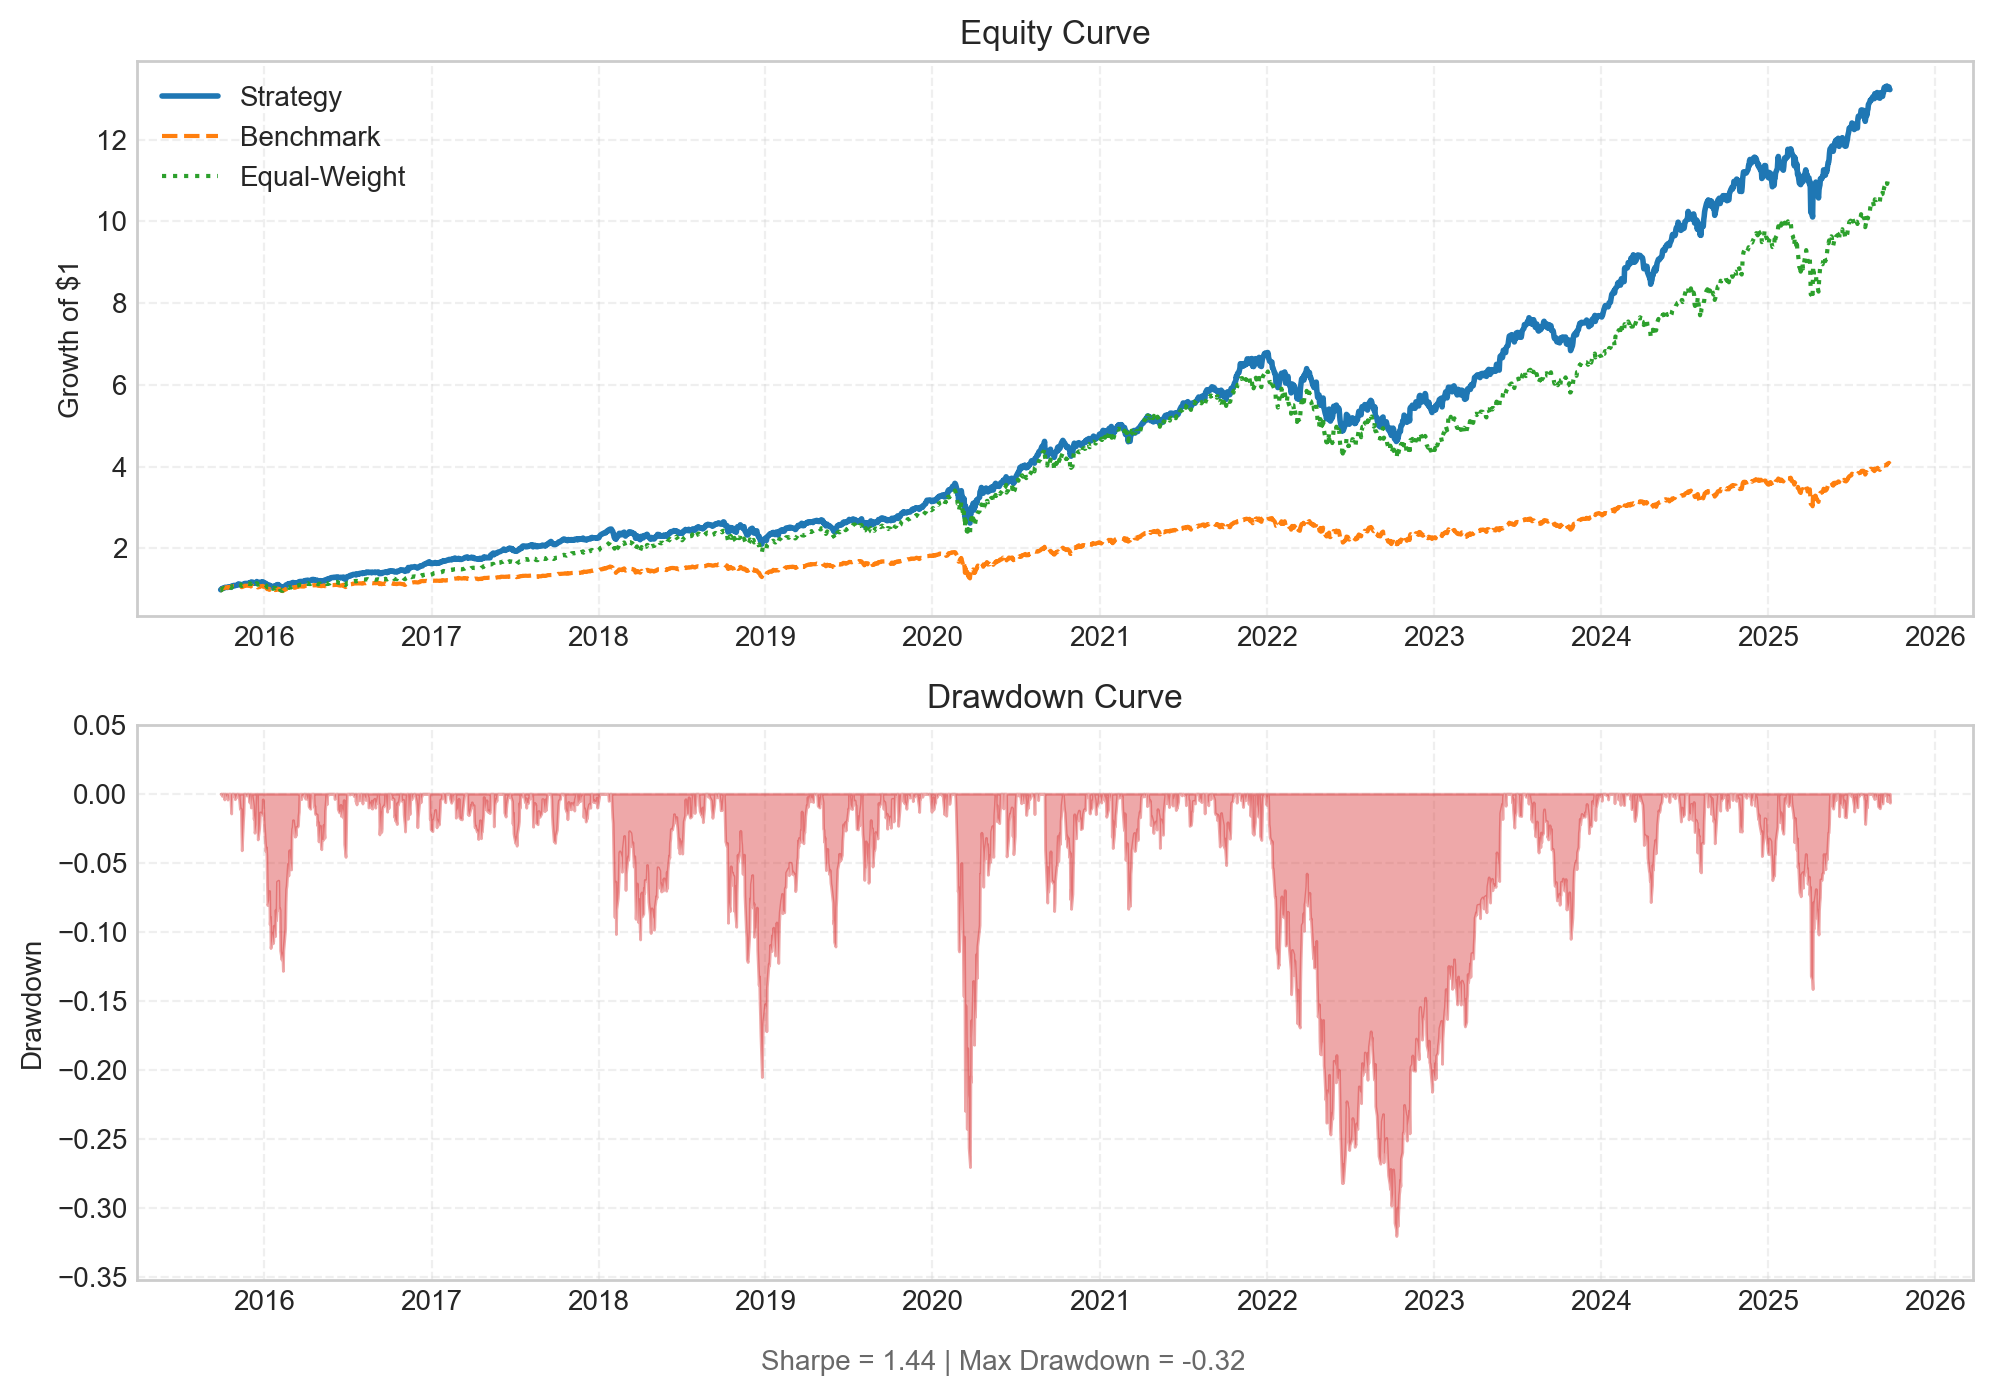

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
plot_equity_curve(portfolio_returns, benchmark_returns, ax=axes[0])
# Add equal-weight curve for comparison
try:
    from portfolio.performance.visualization import prepare_equity_curve
    ew_weights = pd.Series(1.0/asset_returns.shape[1], index=asset_returns.columns)
    ew_returns = (asset_returns * ew_weights).sum(axis=1)
    ew_curve = prepare_equity_curve(ew_returns)
    axes[0].plot(ew_curve.index, ew_curve.values, label="Equal-Weight", linestyle=":")
    axes[0].legend(loc="best")
except Exception:
    pass

plot_drawdown_curve(portfolio_returns, ax=axes[1])

# Caption under the figure with Sharpe and Max Drawdown (using standardized metrics)
try:
    sharpe_val = float(standardized_metrics.get("sharpe_ratio", 0.0))
    mdd_val = float(standardized_metrics.get("max_drawdown", 0.0))
    fig.text(0.5, 0.01, f"Sharpe = {sharpe_val:.2f} | Max Drawdown = {mdd_val:.2f}",
             ha="center", va="bottom", fontsize=10, color="dimgray")
except Exception:
    pass

plt.tight_layout(rect=[0, 0.03, 1, 1])
from IPython.display import display
# Handle display(fig) gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass

# Save figure (overwrite existing path)
fig.savefig(os.path.join(FIG_DIR, "equity_and_drawdown.png"), dpi=150)

## Efficient Frontier

Scatter colored by Sharpe; saved to `examples/figures/efficient_frontier.png`.


[*********************100%***********************]  16 of 16 completed


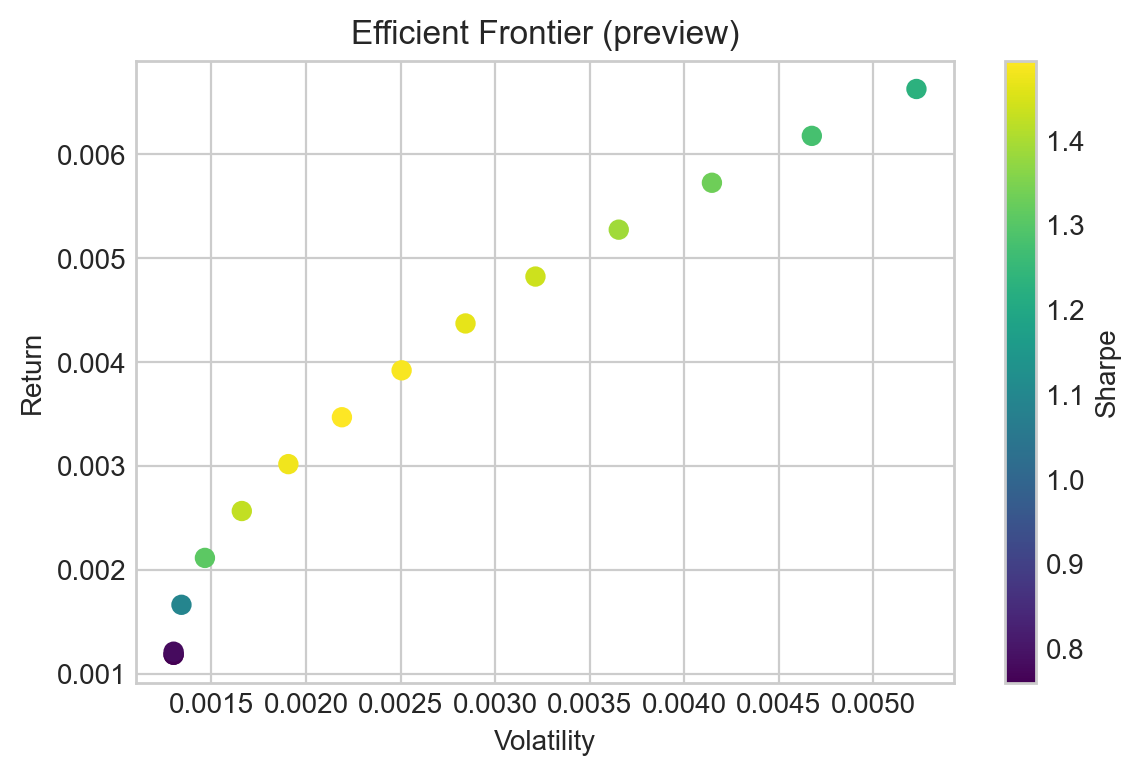

In [11]:
# Efficient frontier preview
frontier = opt.get_efficient_frontier(symbols, n_points=15)

if frontier:
    fr = pd.DataFrame(frontier)
    # Standardize return and volatility to decimals for consistency
    fr['return'] = fr['return'] / 100.0
    fr['volatility'] = fr['volatility'] / 100.0
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(fr["volatility"], fr["return"], c=fr["sharpe_ratio"], cmap="viridis", s=40)
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.set_title("Efficient Frontier (preview)")
    cbar = plt.colorbar(sc, ax=ax, label="Sharpe")
    plt.tight_layout()
    from IPython.display import display
    # Handle display(fig) gracefully for non-interactive environments
    try:
        display(fig)
    except Exception:
        # Silently handle the case where display is not available
        pass
    fig.savefig(os.path.join(FIG_DIR, "efficient_frontier.png"), dpi=150)
else:
    print("Efficient frontier not available (insufficient data).")

## Parameter Sweep

Explore how risk model, weight cap, and entropy affect expected Sharpe/vol/return. 
**Updated focus on feasible constraint ranges:**

- **Weight caps**: `[None, 0.35, 0.30, 0.25, 0.20]` (feasible range)
- **Entropy penalties**: `[0.0, 0.01, 0.02, 0.03]` (moderate range)

Key findings:
- Shrinkage covariances (Ledoit–Wolf, OAS) often top Sharpe
- Small entropy (0.01–0.02) provides good diversification impact
- Weight caps of 0.25-0.30 offer good feasibility vs diversification balance
- Use this grid to justify the updated defaults (cap=0.25, entropy=0.02)

In [12]:
# Updated parameter grid focusing on feasible ranges
from itertools import product

risk_models = ["sample", "ledoit_wolf", "oas"]
weight_caps = [None, 0.35, 0.30, 0.25, 0.20]  # Focus on feasible range
entropy_penalties = [0.0, 0.01, 0.02, 0.03]   # Moderate entropy range

records = []
for rm, cap, ent in product(risk_models, weight_caps, entropy_penalties):
    res = opt.mean_variance_optimize(
        asset_returns,
        risk_model=rm,
        weight_cap=cap,
        entropy_penalty=ent,
    )
    # Standardize metrics to decimals for consistency
    record = {
        "risk_model": rm,
        "weight_cap": cap,
        "weight_cap_display": ("unconstrained" if cap is None else cap),
        "entropy": ent,
        "sharpe": float(res.get("sharpe_ratio", 0)),
        "vol": float(res.get("expected_volatility", 0)) / 100.0,  # Convert to decimal
        "ret": float(res.get("expected_return", 0)) / 100.0,      # Convert to decimal
    }
    records.append(record)

summary = pd.DataFrame(records)
view = summary.sort_values(by=["sharpe", "ret"], ascending=[False, False])[
    ["risk_model", "weight_cap_display", "entropy", "sharpe", "vol", "ret"]
].rename(columns={"weight_cap_display": "weight_cap"})

# Helpful filtered views
constrained = view[view["weight_cap"] != "unconstrained"]
focus_025 = view.query("weight_cap == 0.25")

with pd.option_context('display.float_format', lambda x: f"{x:.6f}"):
    print("Top overall (in-sample):\n" + view.head(12).to_string(index=False))
    if not constrained.empty:
        print("\nTop constrained (cap != unconstrained):\n" + constrained.head(12).to_string(index=False))
    if not focus_025.empty:
        print("\nFocus on cap = 0.25 (new default):\n" + focus_025.sort_values(["sharpe","ret"], ascending=[False, False]).to_string(index=False))

Top overall (in-sample):
 risk_model    weight_cap  entropy   sharpe      vol      ret
ledoit_wolf unconstrained 0.030000 1.376221 0.004858 0.006885
        oas unconstrained 0.030000 1.373681 0.004867 0.006885
     sample unconstrained 0.030000 1.372401 0.004871 0.006885
ledoit_wolf unconstrained 0.020000 1.368851 0.004931 0.006950
        oas unconstrained 0.020000 1.366386 0.004940 0.006950
     sample unconstrained 0.020000 1.365137 0.004945 0.006950
ledoit_wolf unconstrained 0.010000 1.363793 0.004976 0.006986
ledoit_wolf unconstrained 0.000000 1.363591 0.004978 0.006988
        oas unconstrained 0.010000 1.361360 0.004985 0.006986
        oas unconstrained 0.000000 1.361158 0.004987 0.006988
     sample unconstrained 0.010000 1.360117 0.004989 0.006986
     sample unconstrained 0.000000 1.359915 0.004991 0.006988

Top constrained (cap != unconstrained):
 risk_model weight_cap  entropy   sharpe      vol      ret
ledoit_wolf   0.300000 0.030000 1.297747 0.003524 0.004773
ledoit_wol

## Save Key Artifacts

Saves: `weights_mvo.csv`, `metrics_mvo.csv`, and optionally `efficient_frontier.csv` to `examples/outputs/`.


In [13]:
# Save key artifacts - weights and metrics for the best performing method (CVaR)
# Save weights as two columns: symbol,weight (no leading column)
weights = results['CVaR']['weights']
weights_df = pd.DataFrame({
    'symbol': weights.index,
    'weight': weights.values
})
weights_df.to_csv(os.path.join(OUT_DIR, "weights_cvar.csv"), index=False)

# Save metrics as two columns: metric,value (standardize to decimals)
metrics_df = pd.DataFrame({
    'metric': list(standardized_metrics.keys()),
    'value': [float(v) if isinstance(v, (int, float, np.number)) else str(v) for v in standardized_metrics.values()]
})
metrics_df.to_csv(os.path.join(OUT_DIR, "metrics_cvar.csv"), index=False)

# Frontier points (if available) - expand weights to columns instead of dict string
if 'frontier' in globals() and frontier:
    # Create a clean frontier DataFrame with expanded weights
    frontier_data = []
    for point in frontier:
        if 'weights' in point and isinstance(point['weights'], dict):
            # Create a row with basic metrics plus individual weights (standardize to decimals)
            row = {
                'return': point.get('return', 0) / 100.0,      # Convert to decimal
                'volatility': point.get('volatility', 0) / 100.0,  # Convert to decimal
                'sharpe_ratio': point.get('sharpe_ratio', 0)
            }
            # Add individual weights as columns
            for symbol in symbols:
                row[symbol] = point['weights'].get(symbol, 0)
            frontier_data.append(row)
    
    if frontier_data:
        frontier_df = pd.DataFrame(frontier_data)
        # Remove duplicates based on return and volatility
        frontier_df = frontier_df.drop_duplicates(subset=['return', 'volatility'])
        frontier_df.to_csv(os.path.join(OUT_DIR, "efficient_frontier.csv"), index=False)

print("Artifacts saved to:", OUT_DIR)
print(f"- Weights saved to: weights_cvar.csv")
print(f"- Metrics saved to: metrics_cvar.csv")

Artifacts saved to: examples\outputs
- Weights saved to: weights_cvar.csv
- Metrics saved to: metrics_cvar.csv


## Full-data ML training (multi-symbol, long horizon)

This section trains the selected model across multiple symbols over a long historical period (e.g., 10y or max). Configure symbols, period, model, and GPU usage below.


In [ ]:
# Cell 27C: Black-Litterman Confidence Sensitivity
# This cell analyzes different confidence levels for Black-Litterman optimization

try:
    # Check if required variables exist
    if 'opt' not in globals() or 'perf' not in globals():
        raise ValueError("Optimization and performance calculators not available")
    
    if 'asset_returns' not in globals():
        raise ValueError("Asset returns data not available")
    
    if 'benchmark_returns' not in globals():
        print("Warning: Benchmark returns not available, using None")
        benchmark_returns = None
    
    print("\n=== Black-Litterman View Sensitivity ===")

    # Test different confidence levels for Black-Litterman
    confidence_levels = [0.5, 1.0, 2.0]
    bl_results = []

    for conf in confidence_levels:
        try:
            # Note: This assumes the Black-Litterman optimizer accepts a confidence parameter
            bl = opt.black_litterman_optimize(asset_returns, confidence=conf)
            weights = pd.Series(bl['weights'])
            returns = (asset_returns * weights).sum(axis=1)
            metrics = perf.calculate_metrics(returns, benchmark_returns)
            
            bl_results.append({
                'confidence': conf,
                'sharpe_ratio': metrics['sharpe_ratio'],
                'annual_return': metrics['annual_return'],
                'annual_volatility': metrics['annual_volatility'],
                'max_drawdown': metrics['max_drawdown']
            })
        except Exception as e:
            print(f"Error with confidence {conf}: {e}")

    if bl_results:
        bl_df = pd.DataFrame(bl_results)
        print("\nBlack-Litterman Confidence Sensitivity:")
        print(bl_df.to_string(index=False))
    else:
        print("No Black-Litterman results to display")

    print("\n=== Advanced Analysis Complete ===")
    
except Exception as e:
    print(f"Error in Black-Litterman analysis: {e}")
    print("Please ensure prerequisite cells have been executed.")

In [18]:
# Multi-symbol training over long history (per-symbol metrics)
import time
import logging
import pandas as pd
from portfolio.data.yahoo_service import YahooFinanceService
from portfolio.ml import RandomForestPredictor, XGBoostPredictor

logging.basicConfig(level=logging.INFO)
service = YahooFinanceService(use_offline_data=True, offline_data_dir="data")

results = []
for sym in ML_SYMBOLS:
    try:
        data = service.fetch_historical_data(sym, period=ML_PERIOD)
        if data is None or data.empty:
            continue

        model = (
            XGBoostPredictor(device=ML_DEVICE)
            if ML_MODEL == "xgb"
            else RandomForestPredictor()
        )

        feats = model.create_features(data)
        if feats is None or feats.empty:
            continue
        X, y = model.prepare_features(feats)
        if len(X) < ML_MIN_SAMPLES:
            continue

        t0 = time.time()
        metrics = model.train(X, y)
        val = model.validate_model(X, y)
        elapsed = time.time() - t0

        results.append({
            "symbol": sym,
            "n": int(len(feats)),
            "features": int(X.shape[1]),
            "device": metrics.get("device", "cpu" if ML_MODEL == "rf" else ML_DEVICE),
            "train_r2": float(metrics.get("train_r2", float("nan"))),
            "test_r2": float(metrics.get("test_r2", float("nan"))),
            "cv_mse": float(metrics.get("cv_mse", float("nan"))),
            "directional_accuracy": float(val.get("directional_accuracy", float("nan"))),
            "sec": round(elapsed, 2),
        })
    except Exception as e:
        logging.warning(f"{sym}: {e}")

results_df = pd.DataFrame(results).sort_values("test_r2", ascending=False)
results_df


2025-09-25 02:48:25,412 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-25 02:48:25,420 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (10y): 2514 rows
2025-09-25 02:48:25,431 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-25 02:48:25,433 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-25 02:48:27,161 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.1782, CV MSE: 0.000388
2025-09-25 02:48:27,176 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (10y): 2514 rows
2025-09-25 02:48:27,193 - portfolio.ml.predictor - INFO - Created 33 features from 2514 rows
2025-09-25 02:48:27,196 - portfolio.ml.predictor - INFO - Prepared 24 features for 2493 samples
2025-09-25 02:48:29,150 - portfolio.ml.predictor - INFO - XGBoost trained (device=cpu). Test R²: -0.2663, CV MSE: 0.000347
2025-09-25 02:48:29,164 - portfolio.data.yahoo_service - INF

,symbol,n,features,device,train_r2,test_r2,cv_mse,directional_accuracy,sec
13,DIS,2493,24,cpu,0.910455,-0.036726,0.000391,0.828319,1.68
6,TSLA,2493,24,cpu,0.907945,-0.099669,0.001504,0.825913,1.68
15,ADBE,2493,24,cpu,0.920282,-0.142793,0.000592,0.828319,1.80
0,AAPL,2493,24,cpu,0.918847,-0.178235,0.000388,0.829523,1.73
3,AMZN,2493,24,cpu,0.922652,-0.198537,0.000542,0.838347,2.22
5,NVDA,2493,24,cpu,0.923963,-0.216241,0.001205,0.835941,1.53
2,GOOGL,2493,24,cpu,0.916458,-0.242232,0.000355,0.823105,2.07
11,PG,2493,24,cpu,0.913098,-0.258804,0.000178,0.831127,1.70
1,MSFT,2493,24,cpu,0.920854,-0.266333,0.000347,0.832732,1.96
8,MA,2493,24,cpu,0.922686,-0.267870,0.000383,0.827918,2.23


In [ ]:
# Cell 29: Realized Metrics for CVaR and Black-Litterman
# This cell calculates and displays realized performance metrics for CVaR and BL strategies
# Includes defensive programming to handle missing variables

try:
    # Check if required variables are available
    if 'cvar' not in globals():
        print("Warning: CVaR optimization results not found. Running standalone CVaR...")
        opt = SimplePortfolioOptimizer()
        cvar = opt.cvar_optimize(asset_returns, alpha=0.05)
    
    if 'bl' not in globals():
        print("Warning: Black-Litterman optimization results not found. Running standalone BL...")
        opt = SimplePortfolioOptimizer()
        bl = opt.black_litterman_optimize(asset_returns)
    
    if 'asset_returns' not in globals():
        raise ValueError("Asset returns data not available")
    
    if 'benchmark_returns' not in globals():
        print("Warning: Benchmark returns not available, using None")
        benchmark_returns = None
    
    if 'perf' not in globals():
        print("Warning: Performance calculator not available, creating new instance...")
        perf = SimplePerformanceCalculator()
    
    # Calculate weights and returns for CVaR
    w_cvar = pd.Series(cvar["weights"])
    r_cvar = (asset_returns * w_cvar).sum(axis=1)
    
    # Calculate weights and returns for Black-Litterman
    w_bl = pd.Series(bl["weights"])
    r_bl = (asset_returns * w_bl).sum(axis=1)
    
    # Calculate performance metrics
    m_cvar = perf.calculate_metrics(r_cvar, benchmark_returns)
    m_bl = perf.calculate_metrics(r_bl, benchmark_returns)
    
    # Display CVaR metrics
    print("CVaR realized metrics:")
    for k, v in m_cvar.items():
        if isinstance(v, (int, float)):
            if k in ['total_return', 'annual_return', 'annual_volatility', 'max_drawdown', 'beta', 'alpha']:
                print(f"{k}: {v:.4f}")
            else:
                print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    print("\nBL realized metrics:")
    for k, v in m_bl.items():
        if isinstance(v, (int, float)):
            if k in ['total_return', 'annual_return', 'annual_volatility', 'max_drawdown', 'beta', 'alpha']:
                print(f"{k}: {v:.4f}")
            else:
                print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    # Keep standardized versions for backward compatibility
    standardized_m_cvar = m_cvar.copy()
    standardized_m_bl = m_bl.copy()
    
    print("\nCVaR realized (standardized):", {k: (round(v,4) if isinstance(v,(int,float)) else v) for k,v in standardized_m_cvar.items()})
    print("BL realized (standardized):",   {k: (round(v,4) if isinstance(v,(int,float)) else v) for k,v in standardized_m_bl.items()})
    
except Exception as e:
    print(f"Error calculating CVaR/BL realized metrics: {e}")
    print("Please ensure prerequisite cells have been executed.")
    
    # Create empty standardized metrics to prevent downstream errors
    if 'standardized_m_cvar' not in globals():
        standardized_m_cvar = {}
    if 'standardized_m_bl' not in globals():
        standardized_m_bl = {}
    print("Created empty standardized metric dictionaries")

## Backtest setup and interpretation
- Walk‑forward: 3y train / 2q test; rebalanced each test window with 7.5 bps transaction costs.
- Strategies include MVO (unconstrained/capped), CVaR, BL, Equal‑Weight, and the ML overlay.
- The ML overlay tilt (ml_tilt_alpha) is read from the saved recommendation when available.
- Metrics are net‑of‑cost and include Sharpe, Sortino, Calmar, ENH (effective holdings), turnover, and beta.

Walk‑forward with a small train/test split and optional ML overlay. Focus on Sharpe, drawdown, and turnover; figures saved under `examples/figures/`.

In [20]:
# Configure and run a rigorous backtest window (prioritize results over speed)
from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Try to read recommended ML tilt alpha from previous sweep; default to 0.2 if not present
rec_alpha = 0.2
try:
    rec_path = os.path.join(OUT_DIR, "alpha_sweep_recommendation.txt")
    if os.path.exists(rec_path):
        import re
        with open(rec_path, "r", encoding="utf-8") as f:
            m = re.search(r"alpha .*?([0-9.]+)", f.read())
            if m:
                rec_alpha = float(m.group(1))
except Exception:
    pass

bt_cfg = BacktestConfig(
    train_years=3,
    test_quarters=2,
    include_ml_overlay=True,  # keep ML in the flow
    ml_tilt_alpha=rec_alpha,
)
backtester = WalkForwardBacktester(bt_cfg)

start_date = (prices.index.min()).strftime("%Y-%m-%d")
end_date = (prices.index.max()).strftime("%Y-%m-%d")

bt_results = backtester.run_backtest(symbols, start_date, end_date)
print("Strategies:", list(bt_results.keys()))

report = backtester.generate_report(bt_results)
print(report)

2025-09-25 02:48:55,005 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-25 02:48:55,006 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-25 02:48:55,006 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-25 02:48:55,007 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24
2025-09-25 02:48:55,023 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-25 02:48:55,038 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-25 02:48:55,053 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-25 02:48:55,069 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-25 02:48:55,083 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5

Strategies: ['mv_unconstrained', 'mv_capped_18', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'ml_overlay', 'optimized', 'spy', 'comparison']
WALK-FORWARD BACKTESTING REPORT

Configuration:
  Training Period: 3 year(s)
  Testing Period: 2 quarter(s)
  Transaction Costs: 7.5 bps
  Rebalance Frequency: quarterly

--- MV_UNCONSTRAINED STRATEGY ---
Performance Metrics:
  Total Return: 31.38%
  Annual Return: 50.23%
  Annual Volatility: 43.11%
  Sharpe Ratio: 1.12
  Sortino Ratio: 1.75
  Max Drawdown: -30.02%
  Calmar Ratio: 1.67

Trading Metrics:
  Total Transaction Costs: 0.0750%
  Annual Turnover: 99.98%
  Win Rate: 53.8%

--- MV_CAPPED_18 STRATEGY ---
Performance Metrics:
  Total Return: 20.67%
  Annual Return: 32.34%
  Annual Volatility: 31.05%
  Sharpe Ratio: 0.98
  Sortino Ratio: 1.53
  Max Drawdown: -20.17%
  Calmar Ratio: 1.60

Trading Metrics:
  Total Transaction Costs: 0.0543%
  Annual Turnover: 72.44%
  Win Rate: 52.7%

--- CVAR_CAPPED_20 STRATEGY ---
Performan

## Alpha Sweep

Runs the RF‑tilt alpha sweep, saves the table to `examples/outputs/alpha_sweep.csv`,
and saves the Sharpe vs alpha plot to `examples/figures/ml_tilt_alpha_sweep.png`.


2025-09-25 02:49:23,141 - portfolio.optimizer.optimizer - INFO - Initialized SimplePortfolioOptimizer
2025-09-25 02:49:23,141 - portfolio.data.yahoo_service - INFO - Initialized YahooFinanceService
2025-09-25 02:49:23,142 - portfolio.backtesting.walk_forward - INFO - Initialized WalkForwardBacktester with 3y train, 2q test, 7.5bps costs
2025-09-25 02:49:23,142 - portfolio.backtesting.walk_forward - INFO - Fetching data for 16 symbols from 2015-09-25 to 2025-09-24
2025-09-25 02:49:23,148 - portfolio.data.yahoo_service - INFO - Loaded offline data for AAPL (5y): 1255 rows
2025-09-25 02:49:23,153 - portfolio.data.yahoo_service - INFO - Loaded offline data for MSFT (5y): 1255 rows
2025-09-25 02:49:23,158 - portfolio.data.yahoo_service - INFO - Loaded offline data for GOOGL (5y): 1255 rows
2025-09-25 02:49:23,162 - portfolio.data.yahoo_service - INFO - Loaded offline data for AMZN (5y): 1255 rows
2025-09-25 02:49:23,167 - portfolio.data.yahoo_service - INFO - Loaded offline data for META (5

 alpha  sharpe    vol    ret     mdd  turnover  tx_costs
0.4000  0.9980 0.0031 0.0033 -0.0020    0.7356    0.0006
0.3000  0.9923 0.0031 0.0033 -0.0020    0.7327    0.0005
0.0000  0.9869 0.0031 0.0033 -0.0020    0.7298    0.0005
0.2000  0.9869 0.0031 0.0033 -0.0020    0.7298    0.0005
0.1000  0.9818 0.0031 0.0032 -0.0020    0.7271    0.0005

Recommended ml_tilt_alpha ≈ 0.40 (Sharpe=1.00, Vol=0.00, MDD=-0.00)
Saved alpha sweep to examples\outputs\alpha_sweep.csv


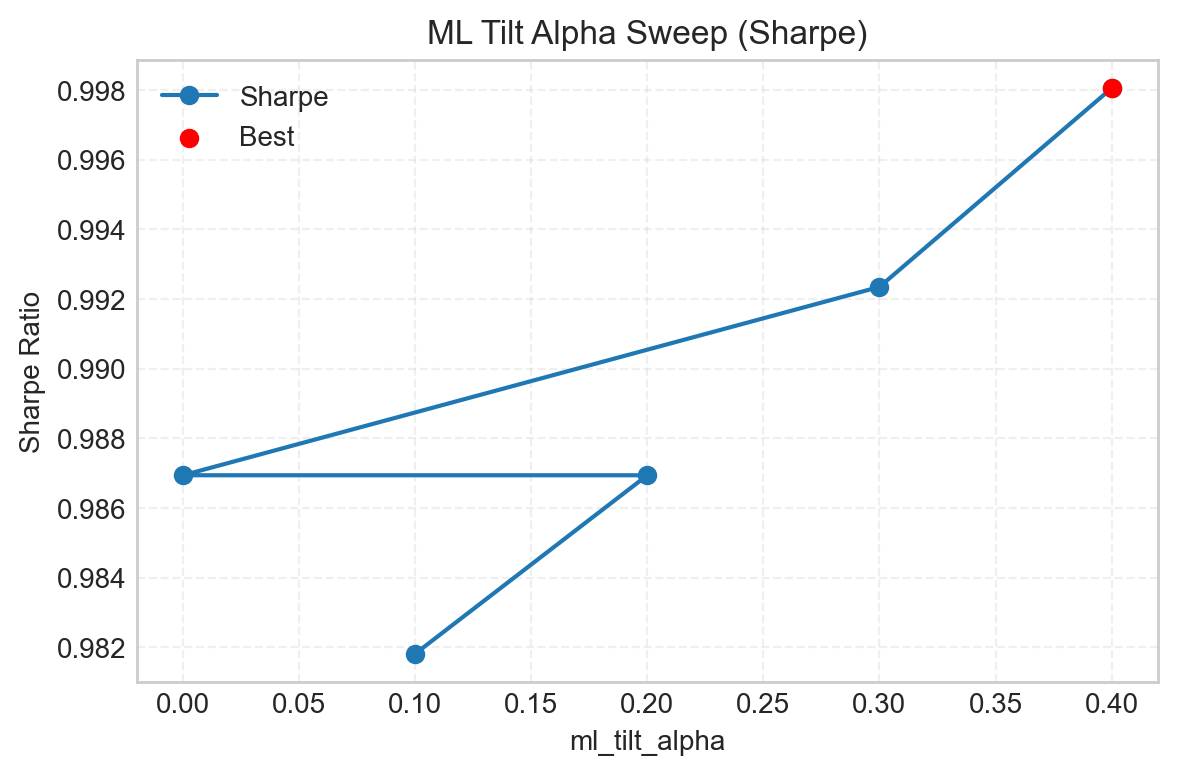

Saved plot to: examples\figures\ml_tilt_alpha_sweep.png


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from portfolio.backtesting.walk_forward import BacktestConfig, WalkForwardBacktester

# Ensure output dirs exist (in case this cell is run standalone)
if 'OUT_DIR' not in globals():
    OUT_DIR = os.path.join('examples', 'outputs')
    os.makedirs(OUT_DIR, exist_ok=True)
if 'FIG_DIR' not in globals():
    FIG_DIR = os.path.join('examples', 'figures')
    os.makedirs(FIG_DIR, exist_ok=True)

# Sweep alphas for the current backtest cadence (3y train / 2q test)
alphas = [0.0, 0.1, 0.2, 0.3, 0.4]
records = []
for a in alphas:
    cfg = BacktestConfig(train_years=3, test_quarters=2, include_ml_overlay=True, ml_tilt_alpha=a)
    bt = WalkForwardBacktester(cfg)
    res = bt.run_backtest(symbols, start_date, end_date)
    r = res.get('ml_overlay')
    if r is None or (getattr(r, 'metrics', None) is None):
        continue
    m = r.metrics
    # Standardize metrics to decimals for consistency
    record = {
        'alpha': a,
        'sharpe': float(m.get('sharpe_ratio', 0.0)),
        'vol': float(m.get('annual_volatility', 0.0)) / 100.0,  # Convert to decimal
        'ret': float(m.get('annual_return', 0.0)) / 100.0,      # Convert to decimal
        'mdd': float(m.get('max_drawdown', 0.0)) / 100.0,       # Convert to decimal
        'turnover': float(getattr(r, 'turnover', 0.0)),
        'tx_costs': float(getattr(r, 'transaction_costs', 0.0)),
    }
    records.append(record)

alpha_view = pd.DataFrame(records).sort_values(['sharpe', 'ret'], ascending=[False, False])
with pd.option_context('display.float_format', lambda x: f'{x:.4f}'):
    print(alpha_view.to_string(index=False))

# Save table + recommendation
alpha_csv = os.path.join(OUT_DIR, 'alpha_sweep.csv')
alpha_view.to_csv(alpha_csv, index=False, encoding='utf-8')
if not alpha_view.empty:
    pick = alpha_view.sort_values(['sharpe','ret','turnover'], ascending=[False, False, True]).iloc[0]
    msg = f"Recommended ml_tilt_alpha ≈ {pick['alpha']:.2f} (Sharpe={pick['sharpe']:.2f}, Vol={pick['vol']:.2f}, MDD={pick['mdd']:.2f})"
    print('\n' + msg)
    with open(os.path.join(OUT_DIR, 'alpha_sweep_recommendation.txt'), 'w', encoding='utf-8') as f:
        f.write(msg + '\n')
print(f'Saved alpha sweep to {alpha_csv}')

# Plot + save
if not alpha_view.empty:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(alpha_view['alpha'], alpha_view['sharpe'], marker='o', label='Sharpe')
    best_idx = alpha_view['sharpe'].idxmax()
    br = alpha_view.loc[best_idx]
    ax.scatter([br['alpha']], [br['sharpe']], color='red', zorder=5, label='Best')
    ax.set_xlabel('ml_tilt_alpha')
    ax.set_ylabel('Sharpe Ratio')
    ax.set_title('ML Tilt Alpha Sweep (Sharpe)')
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    # Handle display(fig) gracefully for non-interactive environments
    try:
        display(fig)
    except Exception:
        # Silently handle the case where display is not available
        pass
    plot_path = os.path.join(FIG_DIR, 'ml_tilt_alpha_sweep.png')
    fig.savefig(plot_path, dpi=150)
    # Handle plt.show() gracefully for non-interactive environments
    try:
        plt.show()
    except Exception:
        # Silently handle the case where display is not available
        pass
    print(f'Saved plot to: {plot_path}')

### Multi-strategy equity and drawdown plots (Strategy vs EW vs SPY)

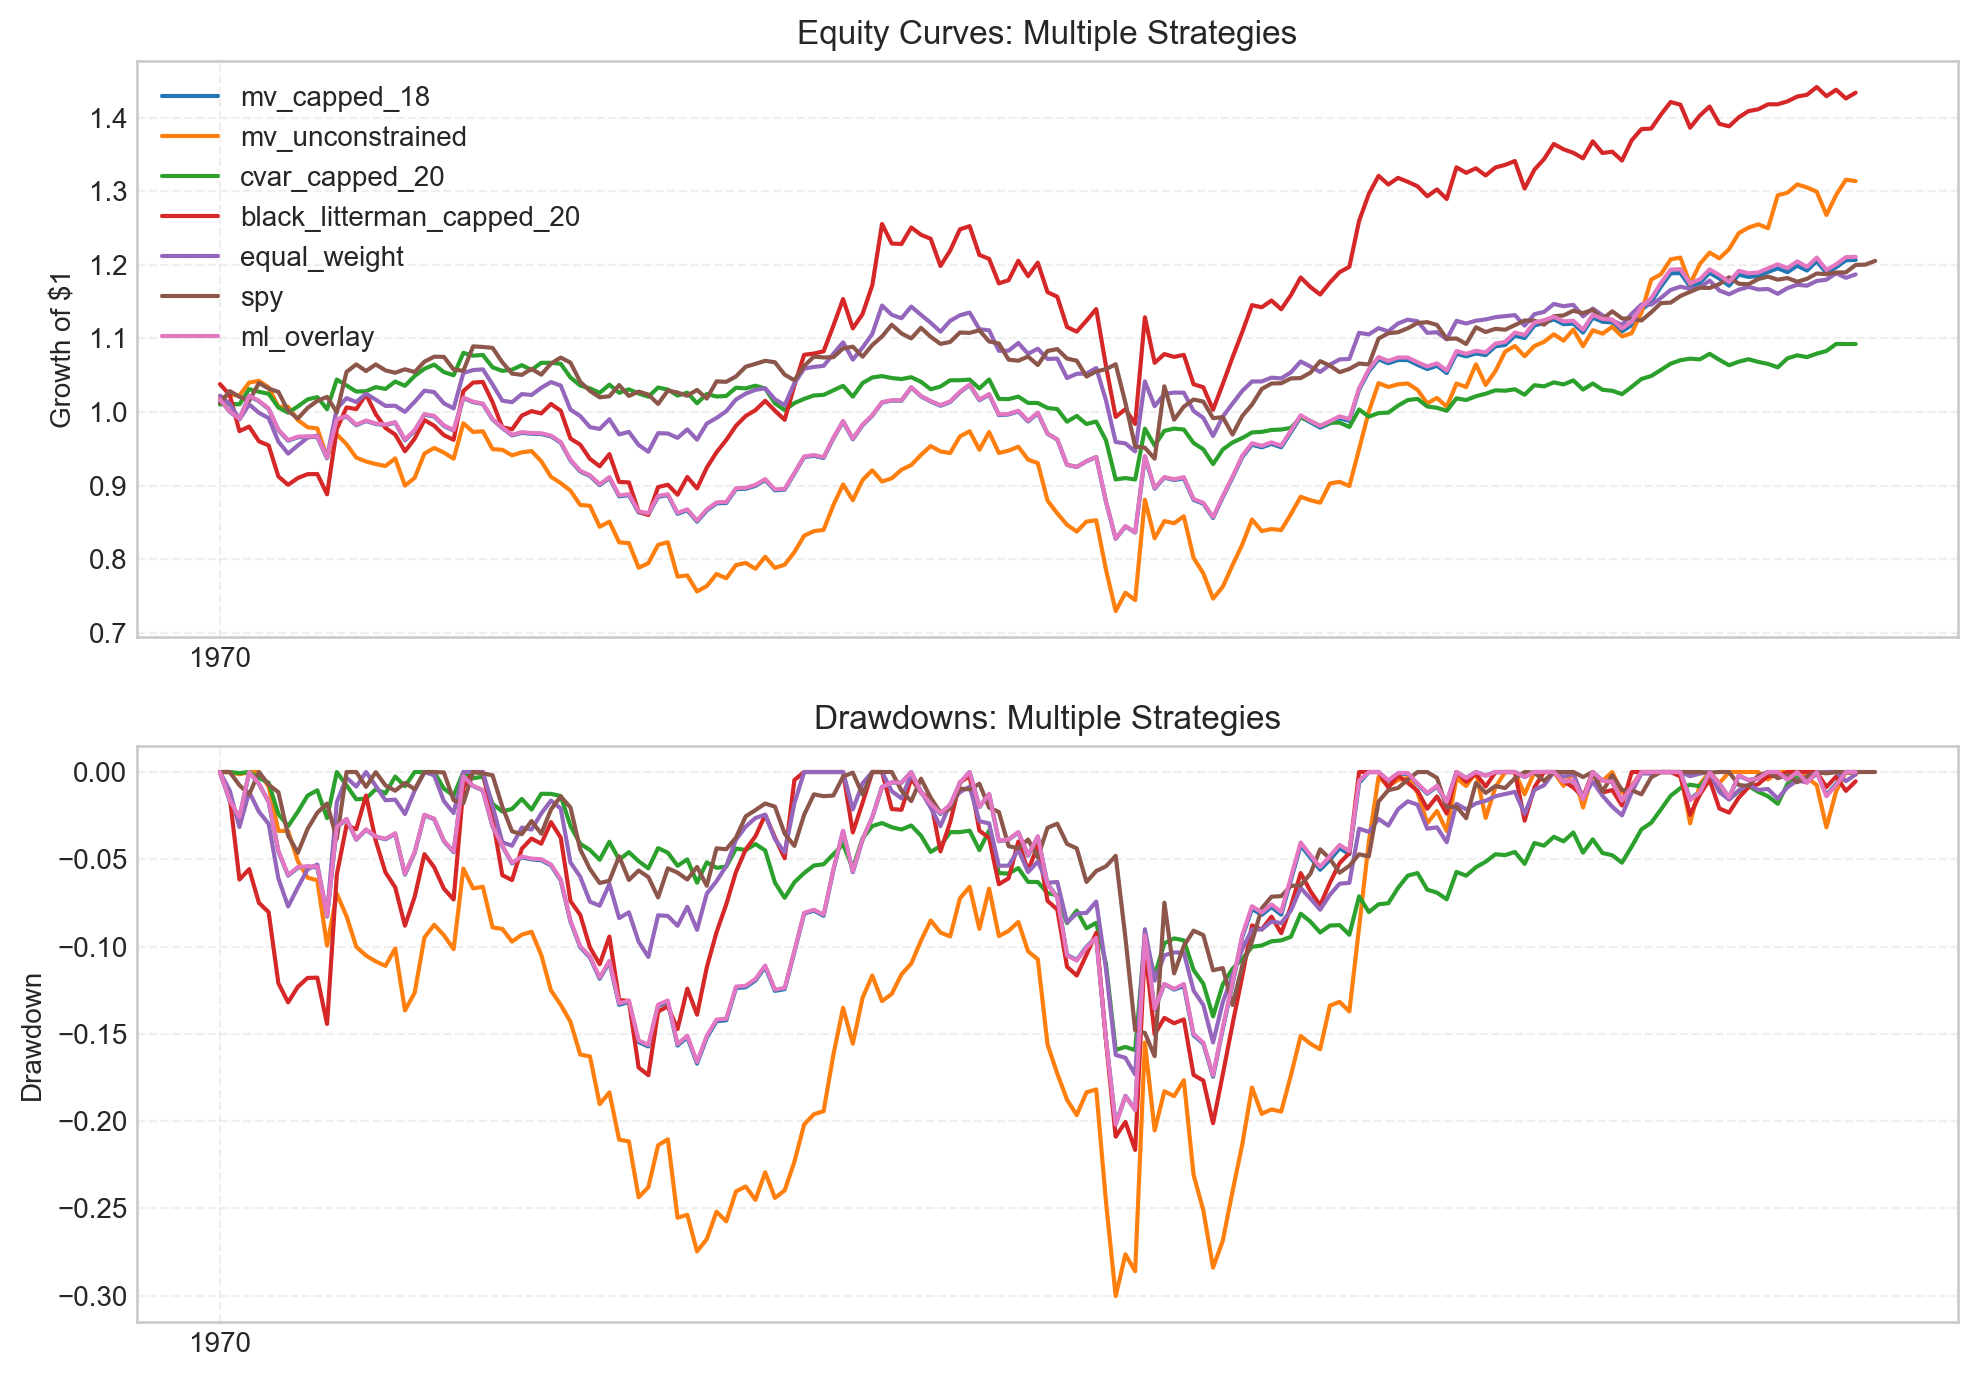

Saved multi-strategy plot to examples/figures/equity_drawdown_multistrategy.png


In [22]:
from portfolio.performance.visualization import prepare_equity_curve, prepare_drawdown_curve

# Collect series from backtest results
# Reflect dynamic capped label based on config (e.g., mv_capped_18)
cap_label = f"mv_capped_{int(round(getattr(bt_cfg, 'max_position_cap', 0.18) * 100))}"
strategies_to_plot = [
    key for key in [
        cap_label, 'mv_unconstrained', 'cvar_capped_20', 'black_litterman_capped_20', 'equal_weight', 'spy', 'ml_overlay'
    ] if key in bt_results
]

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

# Equity curves
for key in strategies_to_plot:
    r = bt_results[key].returns
    if r is None or r.empty:
        continue
    eq = prepare_equity_curve(r)
    axes[0].plot(eq.index, eq.values, label=key)
axes[0].set_title('Equity Curves: Multiple Strategies')
axes[0].set_ylabel('Growth of $1')
axes[0].legend(loc='best')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Drawdowns (overlay)
for key in strategies_to_plot:
    r = bt_results[key].returns
    if r is None or r.empty:
        continue
    dd = prepare_drawdown_curve(r)
    axes[1].plot(dd.index, dd.values, label=key)
axes[1].set_title('Drawdowns: Multiple Strategies')
axes[1].set_ylabel('Drawdown')
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
from IPython.display import display
# Handle display(fig) gracefully for non-interactive environments
try:
    display(fig)
except Exception:
    # Silently handle the case where display is not available
    pass
fig.savefig(os.path.join(FIG_DIR, 'equity_drawdown_multistrategy.png'), dpi=150)
print('Saved multi-strategy plot to examples/figures/equity_drawdown_multistrategy.png')

## API requests if server is running

In [23]:
import json, requests

BASE_URL = "http://127.0.0.1:8000"
try:
    r = requests.get(f"{BASE_URL}/health")
    if r.status_code == 200:
        print("API is reachable")
        # Optimize
        payload = {"symbols": symbols, "target_return": None}
        resp = requests.post(f"{BASE_URL}/optimize", json=payload, timeout=15)
        print("/optimize:", resp.status_code)
        print(list(resp.json().keys()))

        # Analyze
        payload = {"symbols": symbols}
        resp = requests.post(f"{BASE_URL}/analyze", json=payload, timeout=15)
        print("/analyze:", resp.status_code)
        print(list(resp.json().keys()))
    else:
        print("API not responding (status)")
except Exception as e:
    print("API not reachable:", e)

API not reachable: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /health (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002874C117E00>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
